## **MSCI 641 Final Project - Image Caption Generation using deep learning** 

In [1]:
# importing required libraries 

import string
import numpy as np
from PIL import Image
from pickle import dump, load
import numpy as np
import nltk
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from os import listdir
from numpy import array
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook as tqdm

# Mouting the google drive 

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **Pre-processing and cleaning : Captions**

In [2]:
# Function for loading a text file into memory

def load_file(filename):
    # Opening the file as read only
    infile = open(filename, 'r')
    text = infile.read()
    infile.close()
    return text

In [3]:
# Getting all images with their captions

def captions_all_images(filename):
    infile = load_file(filename)
    captions = infile.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions


In [4]:
# Data cleaning- Converting to lower case, removing puntuations and words containing numbers

def clean_captions(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            # converting to lowercase
            desc = [word.lower() for word in desc]
            # removing punctuation from each token
            desc = [word.translate(table) for word in desc]
            # removing hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            # removing tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            # converting back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions


In [5]:
# building a vocabulary of all unique words

def captions_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


In [6]:
# Collating all descriptions into one file 

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    outfile = open(filename,"w")
    outfile.write(data)
    outfile.close()

In [7]:
# Generating and saving file containing clean descriptions - descriptions.txt

dataset_text = "/content/drive/My Drive/Final_MSCI641/data"
dataset_images = "/content/drive/My Drive/Final_MSCI641/data/Final_MSCI641/data/14kimages"
filename = dataset_text + "/" + "14k_captionsamples.txt"
descriptions = captions_all_images(filename)
print("Length of descriptions =" ,len(descriptions))
clean_descriptions = clean_captions(descriptions)
vocabulary = captions_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

# saving clean descriptions to file 
save_descriptions(clean_descriptions, "/content/drive/My Drive/Final_MSCI641/data/descriptions.txt")


Length of descriptions = 14000
Length of vocabulary =  13476


### **Feature Extraction : Images** 

In [ ]:
# Feature extraction - takes 2-4 hours; Can directly proceed to next step and load extracted features from saved file 

def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
# 2048 feature vector
features = extract_features(dataset_images)
dump(features, open("/content/drive/My Drive/Final_MSCI641/data/features_xception.p","wb"))


In [8]:
# Load the above extracted features
features = load(open("/content/drive/My Drive/Final_MSCI641/data/features_xception.p","rb"))

### **Loading Training dataset**

In [9]:
# function for loading images

def load_images(filename):
    infile = load_file(filename)
    photos = infile.split("\n")[:-1]
    return photos

In [10]:
# function for loading clean descriptions for training dataset

def load_clean_descriptions(filename, photos): 
    file = load_file(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [11]:
# Loading the pickle file for previously extracted features

def load_features(photos):
    # loading all features
    all_features = load(open("/content/drive/My Drive/Final_MSCI641/data/features_xception.p","rb"))
    # selecting only needed features
    features = {key_f:all_features[key_f] for key_f in photos}
    return features


In [12]:
filename = dataset_text + "/" + "10k_trainimages_list.txt"
train_imgs = load_images(filename)
train_descriptions = load_clean_descriptions("/content/drive/My Drive/Final_MSCI641/data/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)


### **Tokenizing the vocabulary**

In [13]:
# converting dictionary to clean list of descriptions

def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [14]:
#creating tokenizer class to vectorise the corpus

from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer(lower=True)
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
    


In [15]:
# giving each word an index, and storing that into tokenizer.p pickle file

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('/content/drive/My Drive/Final_MSCI641/data/tokenizer.p', 'wb'))

In [16]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

11795

In [17]:
#calculating maximum length of descriptions

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

72

### **Creating data generator**

In [18]:
#creating input-output sequence pairs from the image description 

def generator_function(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = text_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [19]:
# Returning the input-output sequence pairs in the form of NumPy arrays

def text_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


In [20]:
#shape of the input and output for model for verifying the generator function

[a,b],c = next(generator_function(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((50, 2048), (50, 72), (50, 11795))

### **Defining the neural network model based on CNN-LSTM architecture**

In [21]:
# defining the captioning model using CNN-LSTM architecture 

def CNN_LSTM_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.36)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    # embedding layer 
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)  
    se2 = Dropout(0.36)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu',kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    #  together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/My Drive/Final_MSCI641/data/model.png', show_shapes=True)
    return model


### **Training the CNN-LSTM model for 10 epochs, Using generator function**

In [ ]:
# training our model  #optional to run this cell

print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = CNN_LSTM_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)

#next line to be used in case training is interrupted and should be resumed from last saved model
#model = load_model('/content/drive/My Drive/Final_MSCI641/data/models_output2/model_9.h5')  

for i in range(epochs):
    filepath='/content/drive/My Drive/Final_MSCI641/data/models_output/model_' + str(1+i) + '.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, mode='auto',period=1)
    callbacks_list = [checkpoint]
    generator = generator_function(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1,callbacks=callbacks_list)

Dataset:  10000
Descriptions: train= 10000
Photos: train= 10000
Vocabulary Size: 11795
Description Length:  72
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 72)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 72, 256)      3019520     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_3[0][0]  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
10000/10000 [==============================] - 3648s 365ms/step - loss: 4.7547

Epoch 00001: saving model to /content/drive/My Drive/Final_MSCI641/data/models_output/model_1.h5
Epoch 1/1
10000/10000 [==============================] - 3569s 357ms/step - loss: 4.0193

Epoch 00001: saving model to /content/drive/My Drive/Final_MSCI641/data/models_output/model_2.h5
Epoch 1/1
10000/10000 [==============================] - 3511s 351ms/step - loss: 3.7788

Epoch 00001: saving model to /content/drive/My Drive/Final_MSCI641/data/models_output/model_3.h5
Epoch 1/1
10000/10000 [==============================] - 3460s 346ms/step - loss: 3.6474

Epoch 00001: saving model to /content/drive/My Drive/Final_MSCI641/data/models_output/model_4.h5
Epoch 1/1
10000/10000 [==============================] - 3526s 353ms/step - loss: 3.5628

Epoch 00001: saving model to /content/drive/My Drive/Final_MSCI641/data/models_output/model_5.h5
Epoch 1/1
10000/10000 [==============================] - 3495s 35

### **Inference : Generating description for an unseen image in test dataset**

In [22]:
# extract the features for test image

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
################################################################################

# word-indexing

def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None

################################################################################
# generating the description for the image

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text



start dog is running through the water end




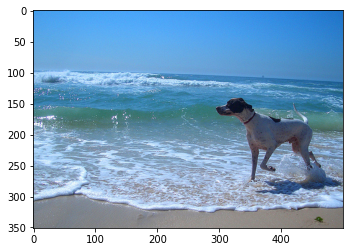

In [24]:
# Calling the above functions to generate caption for the input test image

# image path from testing data
img_path = '/content/drive/My Drive/Final_MSCI641/data/14kimages/2967630001.jpg' 
max_length = 72
tokenizer = load(open("/content/drive/My Drive/Final_MSCI641/data/tokenizer.p","rb"))
# loading the best model (least loss)
model = load_model('/content/drive/My Drive/Final_MSCI641/data/models_output/model_10.h5')  
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
# plotting the image 
print("\n")
plt.imshow(img)
#generating the caption
description = generate_desc(model, tokenizer, photo, max_length) 
print(description)
print("\n")


### **Evaluation : BLEU-1 score**

In [25]:
#preparing test dataset - loading clean testing descriptions (actual)

filename = dataset_text + "/" + "4k_testimages_list.txt"
test_imgs=load_images(filename)
# descriptions
test_descriptions = load_clean_descriptions("/content/drive/My Drive/Final_MSCI641/data/descriptions.txt",test_imgs)
print('Test Dataset: %d' % len(test_descriptions))
# image features
test_features = load_features(test_imgs)
print('Images: test=%d' % len(test_features))
tokenizer = load(open("/content/drive/My Drive/Final_MSCI641/data/tokenizer.p","rb"))
max_length=72

Test Dataset: 4000
Images: test=4000


In [26]:
# function to implement BLEU-1 score : generating a list of predicted captions to compare with actual captions

def evaluate_model(model, descriptionss, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptionss.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

In [27]:
# calculating and calling BLEU-1 score (scale of 0-1)

filename = '/content/drive/My Drive/Final_MSCI641/data/models_output/model_10.h5' 
model = load_model(filename)
# evaluating model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


BLEU-1: 0.353709


# **THANK YOU!**